<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/master/Fed_3_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.6/478.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently

In [2]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset, logging
from datasets.utils.logging import disable_progress_bar

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.12.0 / PyTorch 2.5.1+cu121


# Dataloader

In [3]:
BATCH_SIZE = 32

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def load_datasets(partition_id: int, num_partitions: int):

    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": num_partitions}
    )

    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition = fds.load_partition(partition_id)
    # Divider : 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    #Apply Tranforms
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

### Histogram of the dataset


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

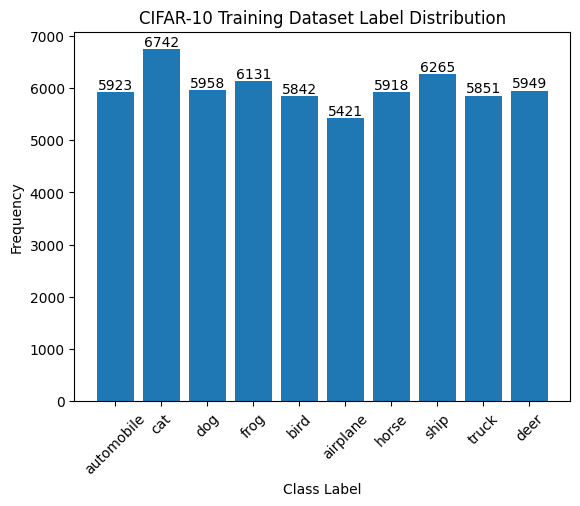

In [5]:
# Download the CIFAR-10 dataset
logging.set_verbosity_error()  # Suppress logs at the error level and below
mninst = load_dataset("mnist")

# Construct histogram for training labels
all_labels = mninst["train"]["label"]
all_label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# Plot formatting
_ = plt.xticks([label for label in all_label_counts.keys()],
               labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
               rotation=45)

plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("CIFAR-10 Training Dataset Label Distribution")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


One Partition has 6000 examples.
One Partition has 4800 examples.
Entropy: 3.3182
Max Entropy (Uniform Distribution): 3.3219
Distribution Uniformity Ratio: 0.9989


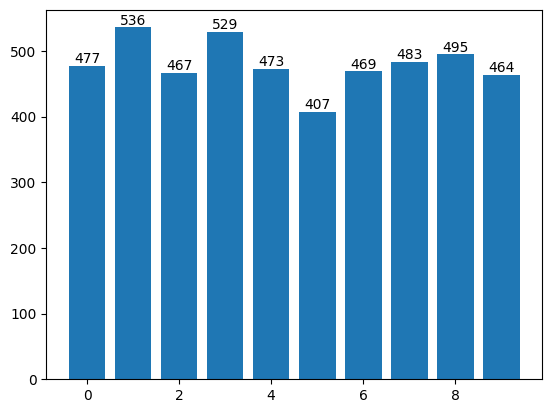

In [6]:
num_partitions = 10  # Total number of participants
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": num_partitions}
)

partition = fds.load_partition(0)
print(f"One Partition has {len(partition)} examples.")

# Divider : 80% train, 20% test
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
train_size = len(partition_train_test["train"])
print(f"One Partition has {train_size} examples.")

all_labels = partition_train_test["train"]["label"]

label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(label_counts.keys(), label_counts.values())
_ = plt.bar_label(bar)

total_count = sum(label_counts.values())

# Calculate proportions
proportions = [count / total_count for count in label_counts.values()]

# Calculate entropy
entropy = -sum(p * np.log2(p) for p in proportions)
max_entropy = np.log2(len(label_counts))  # Maximum entropy for uniform distribution

print(f"Entropy: {entropy:.4f}")
print(f"Max Entropy (Uniform Distribution): {max_entropy:.4f}")
print(f"Distribution Uniformity Ratio: {entropy / max_entropy:.4f}")

so the data is IID

# Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
net = Net()
num_parameters = sum(value.numel() for value in net.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


# Train Test func


In [9]:
def train(net, trainloader, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0

    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Federation

## set-get params


In [10]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

## FlowerClient

In [11]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)

        optim = torch.optim.SGD(self.net.parameters(), lr=0.01, momentum=0.9)
        train(self.net, self.trainloader,optim , epochs=local_epochs)
#============================================================================================
        # model_filename = f"federated_model_{server_round}.pth"
        # torch.save(net.state_dict(), model_filename)
        # print(f"Model saved as {model_filename}")
#============================================================================================
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):

        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)



        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:

    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)

    # print(f"FlowerClient is created")
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Agregation Function

In [12]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [13]:
Agregation_history = []

def My_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m.get("loss", 0.0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Save metrics to history
    Agregation_history.append({
        # "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    print(f"My_weighted_average -{accuracy} {loss} ")

    return {"accuracy": accuracy, "loss": loss}

## Server Evaluate metrics aggregation fn

In [14]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    return loss, {"server_round": server_round, "accuracy": accuracy, "loss": loss}

In [15]:
evaluation_history = []

def My_evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    # Save metrics to history
    evaluation_history.append({
        "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    model_filename = f"federated_model_{server_round}.pth"
    torch.save(net.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")

    return loss, {"accuracy": accuracy}


## Server Fn Strategy

In [16]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 ,
    }
    return config

In [17]:
NUM_CLIENTS = 10

In [18]:
strategy_3 = FedAdagrad(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(get_parameters(net)),
    )

In [19]:
NUM_ROUNDS = 10

In [20]:
params = get_parameters(Net())

In [21]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        # on_evaluate_config_fn,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        # inplace,
    )

    config = ServerConfig(num_rounds = NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config = config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

## RUN


In [22]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07214477286338807, {'accuracy': 0.0982}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07214477286338807 / accuracy 0.0982
Model saved as federated_model_0.pth


(pid=1667) 2024-11-17 23:20:08.002136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1667) 2024-11-17 23:20:08.059106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1667) 2024-11-17 23:20:08.078061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=1667) 2024-11-17 23:20:12.536627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=1667) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1

(ClientAppActor pid=1667) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1668) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.007708026260882616, {'accuracy': 0.9277}, 58.76094033800001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.007708026260882616 / accuracy 0.9277
Model saved as federated_model_1.pth
(ClientAppActor pid=1668) [Client 0] evaluate, config: {}
(ClientAppActor pid=1668) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=1667) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9253333333333333 0.0 
(ClientAppActor pid=1667) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=1667) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.003840006930520758, {'accuracy': 0.9613}, 112.27282316200001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.003840006930520758 / accuracy 0.9613
Model saved as federated_model_2.pth
(ClientAppActor pid=1667) [Client 3] evaluate, config: {}
(ClientAppActor pid=1668) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=1667) [Client 2] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9571666666666667 0.0 
(ClientAppActor pid=1667) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 7] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1667) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 9, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 0.002761611661873758, {'accuracy': 0.9723}, 162.42736546100002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.002761611661873758 / accuracy 0.9723
Model saved as federated_model_3.pth
(ClientAppActor pid=1668) [Client 2] evaluate, config: {}
(ClientAppActor pid=1668) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9716666666666666 0.0 
(ClientAppActor pid=1667) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=1667) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 0.0023710695937508718, {'accuracy': 0.9752}, 214.00587921200002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0023710695937508718 / accuracy 0.9752
Model saved as federated_model_4.pth
(ClientAppActor pid=1667) [Client 1] evaluate, config: {}
(ClientAppActor pid=1668) [Client 1, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=1667) [Client 6] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9747499999999999 0.0 
(ClientAppActor pid=1667) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 9] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1667) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 9, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.001981840694579296, {'accuracy': 0.9793}, 268.73799304900007)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.001981840694579296 / accuracy 0.9793
Model saved as federated_model_5.pth
(ClientAppActor pid=1667) [Client 0] evaluate, config: {}
(ClientAppActor pid=1667) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 4] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9781666666666666 0.0 
(ClientAppActor pid=1667) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=1667) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1668) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 1, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.0017947544398368336, {'accuracy': 0.9814}, 322.482087313)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0017947544398368336 / accuracy 0.9814
Model saved as federated_model_6.pth
(ClientAppActor pid=1668) [Client 2] evaluate, config: {}
(ClientAppActor pid=1667) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 3] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9800833333333333 0.0 
(ClientAppActor pid=1667) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1668) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.0017039369556121529, {'accuracy': 0.9815}, 376.464511611)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0017039369556121529 / accuracy 0.9815
Model saved as federated_model_7.pth
(ClientAppActor pid=1667) [Client 1] evaluate, config: {}
(ClientAppActor pid=1667) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=1667) [Client 0] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9814999999999999 0.0 
(ClientAppActor pid=1667) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1667) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, 0.0014930223283474333, {'accuracy': 0.9835}, 429.431468125)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0014930223283474333 / accuracy 0.9835
Model saved as federated_model_8.pth
(ClientAppActor pid=1667) [Client 3] evaluate, config: {}
(ClientAppActor pid=1667) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 2] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9824166666666665 0.0 
(ClientAppActor pid=1668) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=1667) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1667) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 8, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (9, 0.0013878951111692005, {'accuracy': 0.9851}, 482.80836878400004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0013878951111692005 / accuracy 0.9851
Model saved as federated_model_9.pth
(ClientAppActor pid=1667) [Client 3] evaluate, config: {}
(ClientAppActor pid=1668) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=1668) [Client 2] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9819166666666668 0.0 
(ClientAppActor pid=1668) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=1667) [Client 4] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1668) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1668) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1667) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (10, 0.0012811339006118941, {'accuracy': 0.9871}, 535.6169911970001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0012811339006118941 / accuracy 0.9871
Model saved as federated_model_10.pth
(ClientAppActor pid=1668) [Client 0] evaluate, config: {}
(ClientAppActor pid=1668) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=1667) [Client 9] evaluate, config: {} [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 547.18s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.008071508005882303
INFO :      		round 2: 0.0042728583731999
INFO :      		round 3: 0.0029231138651957733
INFO :      		round 4: 0.0026084266580486044
INFO :      		round 5: 0.0022195492021273825
INFO :      		round 6: 0.0020610670807557955
INFO :      		round 7: 0.001991368618172904
INFO :      		round 8: 0.0018063027344906006
INFO :      		round 9: 0.0017945113152139434
INFO :      		round 10: 0.001618249110649534
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07214477286338807
INFO :      		round 1: 0.007708026260882616
INFO :      		round 2: 0.003840006930520758
INFO :      		round 3: 0.002761611661873758
INFO :      		round 4: 0.0023710695937508718
INFO :      		round 5: 0.001981840694579296
INFO :      		round 6: 0.0017947544398368336
INFO :      

My_weighted_average -0.9846666666666667 0.0 
(ClientAppActor pid=1668) [Client 5] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=1668) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1668) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=1668) see the appropriate new directories, set the environment variable
(ClientAppActor pid=1668) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=1668) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=1668)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


# plots

In [23]:
net.load_state_dict(torch.load("federated_model_3.pth"))
net.eval()
_, valloader, _ = load_datasets(0, 1)
loss, accuracy = test(net, valloader)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-23-ee3b8fdb1208>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

Validation Loss: 0.0028
Validation Accuracy: 0.97%


In [24]:
Agregation_history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'loss': 0.0, 'accuracy': 0.9253333333333333},
 {'loss': 0.0, 'accuracy': 0.9571666666666667},
 {'loss': 0.0, 'accuracy': 0.9716666666666666},
 {'loss': 0.0, 'accuracy': 0.9747499999999999},
 {'loss': 0.0, 'accuracy': 0.9781666666666666},
 {'loss': 0.0, 'accuracy': 0.9800833333333333},
 {'loss': 0.0, 'accuracy': 0.9814999999999999},
 {'loss': 0.0, 'accuracy': 0.9824166666666665},
 {'loss': 0.0, 'accuracy': 0.9819166666666668},
 {'loss': 0.0, 'accuracy': 0.9846666666666667}]

In [25]:
evaluation_history

[{'round': 0, 'loss': 0.07214477286338807, 'accuracy': 0.0982},
 {'round': 1, 'loss': 0.007708026260882616, 'accuracy': 0.9277},
 {'round': 2, 'loss': 0.003840006930520758, 'accuracy': 0.9613},
 {'round': 3, 'loss': 0.002761611661873758, 'accuracy': 0.9723},
 {'round': 4, 'loss': 0.0023710695937508718, 'accuracy': 0.9752},
 {'round': 5, 'loss': 0.001981840694579296, 'accuracy': 0.9793},
 {'round': 6, 'loss': 0.0017947544398368336, 'accuracy': 0.9814},
 {'round': 7, 'loss': 0.0017039369556121529, 'accuracy': 0.9815},
 {'round': 8, 'loss': 0.0014930223283474333, 'accuracy': 0.9835},
 {'round': 9, 'loss': 0.0013878951111692005, 'accuracy': 0.9851},
 {'round': 10, 'loss': 0.0012811339006118941, 'accuracy': 0.9871}]

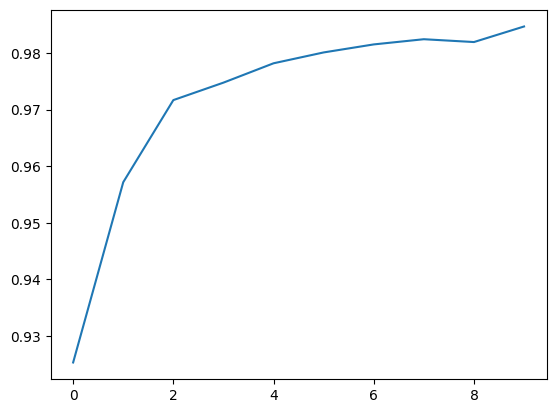

In [26]:
accuracy_values = [d['accuracy'] for d in Agregation_history]
plt.plot(accuracy_values)
plt.show()

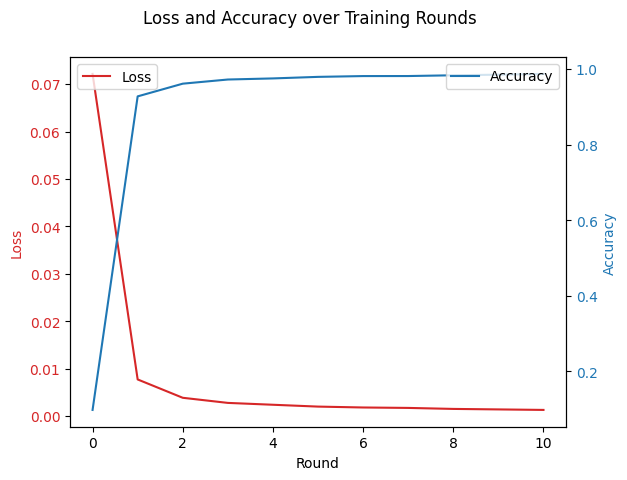

In [27]:
rounds = [entry["round"] for entry in evaluation_history]
loss = [entry["loss"] for entry in evaluation_history]
accuracy = [entry["accuracy"] for entry in evaluation_history]

fig, ax1 = plt.subplots()

# Plot loss on the first y-axis
ax1.set_xlabel("Round")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(rounds, loss, color="tab:red", label="Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.plot(rounds, accuracy, color="tab:blue", label="Accuracy")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Title and legend
fig.suptitle("Loss and Accuracy over Training Rounds")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()
